A.S. Lundervold, v. 170921

# Introduction

This notebook goes through some core concepts related to **regression** in machine learning, based on concrete examples. 

We'll use two data sets for this, of increasing complexity: _vehicles_ and _housing prices_. This notebook goes through the _vehicles_ example. We'll have a look at the housing data later. 

<img src="assets/cars.jpg">

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
# To display plots directly in the notebook:
%matplotlib inline

We import our standard framework:

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn

In [4]:
# Set the directory in which to store data
NB_DIR = Path.cwd()     
DATA = NB_DIR/'data'/'vehicles'     

DATA.mkdir(parents=True, exist_ok=True)

# Understand the problem and look at the big picture

## Frame the problem

Our task will be to predict the price of a car from various descriptive features. One can imaging using this to figure out whether an offered price is fair, or, if you're a car dealer, to decide on your sale price. It can also be used to see if there are interesting general trends linking the price of the car to its features. 

## Select performance measures

If we imagine that our model is to be used as part of a more comprehensive pricing system, the broader picture may influence what performance measures we'd like to use. 

In this case we keep things simple: we just want the predicted price to, on average, correspond to the actual sale price. 

For regression problems, two widely used performance measures are the ***Root Mean Squared Error*** (RMSE) and the ***Mean Absolute Error*** (MAE). 

We'll talk more about these later in the notebook. 

# Get the data

We'll use the data provided by Nehal Birla here: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho. Store it in the `DATA` directory to continue. 

In [5]:
import shutil

In [6]:
shutil.unpack_archive(DATA/'archive.zip', extract_dir=DATA)

There are three different data sets. Let's have a quick look at them to decide which one to use:

In [7]:
list(DATA.iterdir())

[PosixPath('/data-ssd/Dropbox/Jobb/HIB/Kurs/DAT801/repo/notebooks/data/vehicles/Car details v3.csv'),
 PosixPath('/data-ssd/Dropbox/Jobb/HIB/Kurs/DAT801/repo/notebooks/data/vehicles/car data.csv'),
 PosixPath('/data-ssd/Dropbox/Jobb/HIB/Kurs/DAT801/repo/notebooks/data/vehicles/archive.zip'),
 PosixPath('/data-ssd/Dropbox/Jobb/HIB/Kurs/DAT801/repo/notebooks/data/vehicles/CAR DETAILS FROM CAR DEKHO.csv')]

In [8]:
car_data = pd.read_csv('data/vehicles/car data.csv')
car_details = pd.read_csv('data/vehicles/CAR DETAILS FROM CAR DEKHO.csv')
car_details_v3 = pd.read_csv('data/vehicles/Car details v3.csv')

In [9]:
car_data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [10]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [11]:
car_details.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [12]:
car_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [13]:
car_details_v3.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [14]:
car_details_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


Let's use the last one as it has the most features and instances. Note that there are some missing values in `mileage`, `engine`, `max_power`, `torque` and `seats` that we'll have to deal with.

In [15]:
df = car_details_v3.copy()

# Explore the data

In [16]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Feature distributions

Here's a plot of the price distribution in our data:

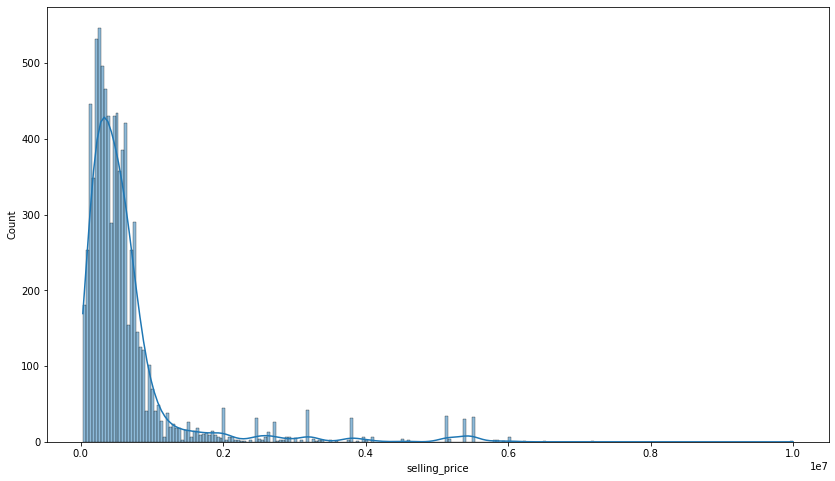

In [17]:
plt.figure(figsize=(14,8))
sns.histplot(df.selling_price, kde=True)
plt.show()

We see that there are some very expensive cars in the data set, but only a few.

How about the distribution of model years?

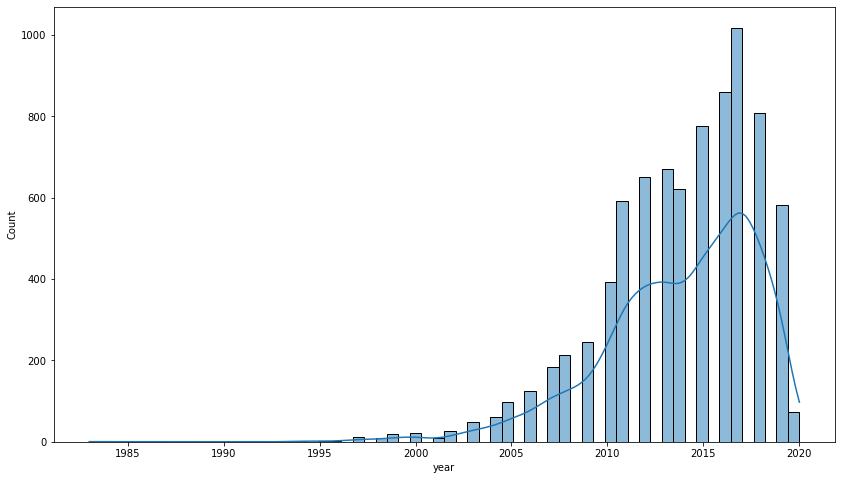

In [18]:
plt.figure(figsize=(14,8))
sns.histplot(df.year, kde=True)
plt.show()

We note that the cars are quite new.

Is there a relationship between the model year and the price? Let's make a new categorical feature to investigate. Based on the above histogram, we say that cars from before 2005 are "old", between 2005 and 2015 are "medium" and 2015-2020 are "new".

In [19]:
df["age_cat"] = pd.cut(df["year"], bins=[1982, 2010, 2015, 2020],
                               labels=['old', 'medium', 'new'])



In [20]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age_cat
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,medium
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,medium
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,old
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,old
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,old


In [21]:
df.age_cat.value_counts()

new       3341
medium    3310
old       1477
Name: age_cat, dtype: int64

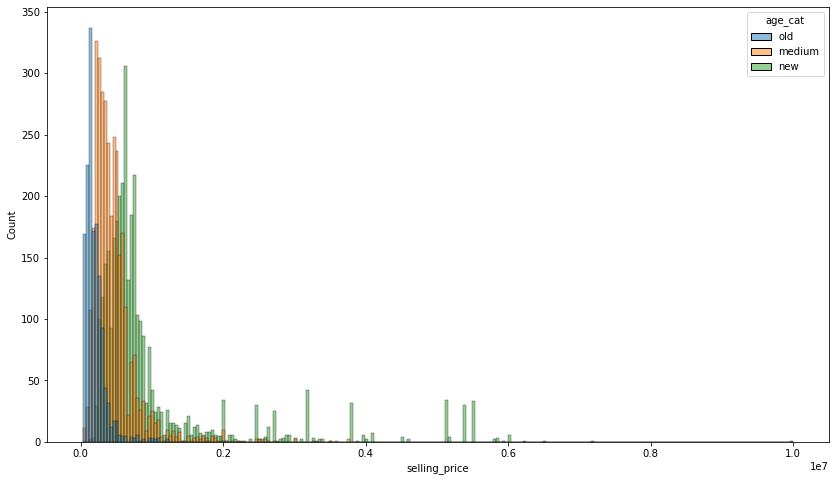

In [22]:
plt.figure(figsize=(14,8))
sns.histplot(data=df, x='selling_price', hue='age_cat')
plt.show()

We observe a tendency for newer cars to be more expensive than older ones. 

What about transmission type?

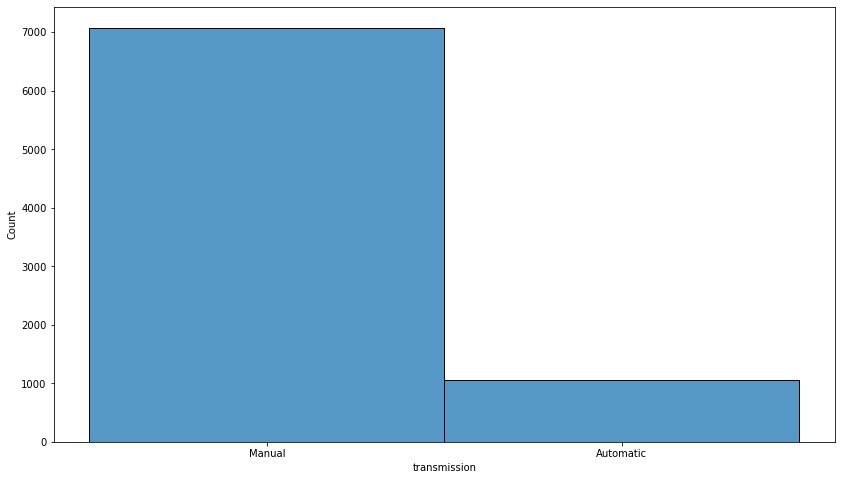

In [23]:
plt.figure(figsize=(14,8))
sns.histplot(df.transmission)
plt.show()

Most are manual transmission. Is there a relationship between the price and the type of transmission?

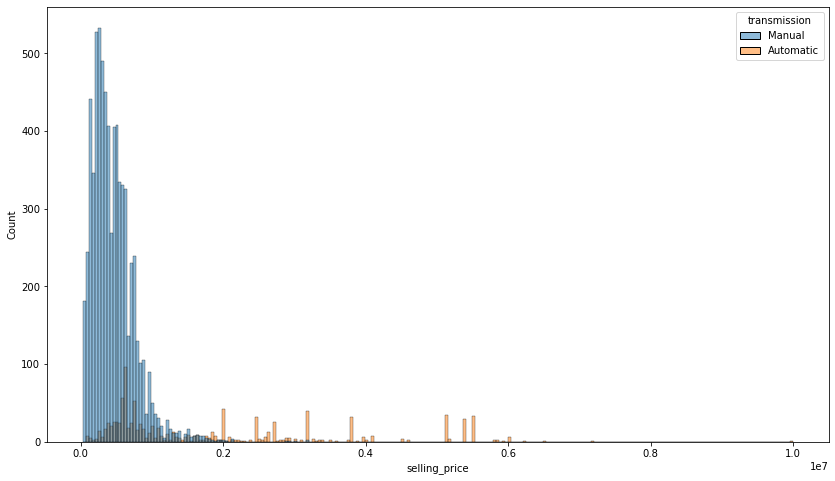

In [24]:
plt.figure(figsize=(14,8))
sns.histplot(data=df, x='selling_price', hue='transmission')
plt.show()

Seems like the automatic transmission cars are pricier. We can see this also by computing their mean prices:

In [25]:
# We find all the rows corresponding to automatic transmission, 
# extract their selling prices, and compute the mean
df.loc[df.transmission=='Automatic'].selling_price.mean()

1870827.6038095239

In [26]:
df.loc[df.transmission=='Manual'].selling_price.mean()

455425.8645097485

How about the fuel and the price?

In [27]:
df.fuel.value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

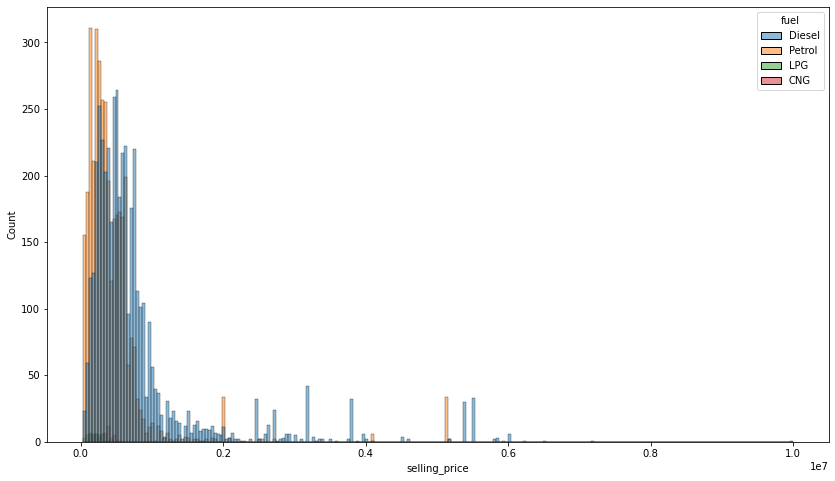

In [28]:
plt.figure(figsize=(14,8))
sns.histplot(data=df, x='selling_price', hue='fuel')
plt.show()

## Converting the features' data types

There are many other features we could investigate in a similar way. But we're quickly faced with the problem that some of them, like the mileage, are numbers, but not stored as such:

In [29]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age_cat
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,medium
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,medium
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,old
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,old
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,old


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           8128 non-null   object  
 1   year           8128 non-null   int64   
 2   selling_price  8128 non-null   int64   
 3   km_driven      8128 non-null   int64   
 4   fuel           8128 non-null   object  
 5   seller_type    8128 non-null   object  
 6   transmission   8128 non-null   object  
 7   owner          8128 non-null   object  
 8   mileage        7907 non-null   object  
 9   engine         7907 non-null   object  
 10  max_power      7913 non-null   object  
 11  torque         7906 non-null   object  
 12  seats          7907 non-null   float64 
 13  age_cat        8128 non-null   category
dtypes: category(1), float64(1), int64(3), object(9)
memory usage: 833.7+ KB


We should convert some of the features stored as strings (`object`) to integers and floats. Specifically, the mileage, the engine size and the max power.

In [31]:
df.mileage.value_counts()

18.9 kmpl      225
19.7 kmpl      173
18.6 kmpl      164
21.1 kmpl      157
17.0 kmpl      133
              ... 
16.34 kmpl       1
19.69 kmpl       1
20.88 km/kg      1
17.8 km/kg       1
16.51 kmpl       1
Name: mileage, Length: 393, dtype: int64

First we remove the units:

In [32]:
df.max_power.value_counts()

74 bhp       377
81.80 bhp    220
88.5 bhp     204
67 bhp       165
46.3 bhp     162
            ... 
203.2 bhp      1
175 bhp        1
57 bhp         1
80.84 bhp      1
135.1 bhp      1
Name: max_power, Length: 322, dtype: int64

In [33]:
df['mileage'] = df.mileage.str.replace(' kmpl', '')
df['mileage'] = df.mileage.str.replace(' km/kg', '')

Then we convert to floats:

In [34]:
df['mileage'] = df['mileage'].astype(float)

Let's do similarly for the others:

In [35]:
df.engine = df.engine.str.replace(' CC', '').astype(float)

In [36]:
df.max_power = df.max_power.str.replace(' bhp', '')
df.max_power = df.max_power.replace('', np.nan)        # Empty strings replaced by NaNs
df.max_power = df.max_power.astype(float)

In [37]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age_cat
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0,medium
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,medium
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0,old
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,old
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0,old


Rather than dealing with the heterogeneity of the torque feature, we'll simply drop it (feel free to do otherwise on your own!)

In [38]:
df.drop('torque', axis=1, inplace=True)

We'll also drop the name of the car. This is to simplify things. A better idea would be to use it to extract information about the make and model of the car. 

In [39]:
df.drop('name', axis=1, inplace=True)

This is now our data set:

In [40]:
df.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age_cat
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,medium
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,medium
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,old
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,old
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,old


## Feature encoding

We need to represent the categorical features `fuel`, `transmission`, `seller_type` and `owner` as numbers for our machine learning models to work. 

How to best do such feature encoding is a relatively large topic. The short version is that we can either do a *on hot encoding* if the feature values are not related to each other in some *ordinal* way (i.e., there's no reason to treat one as "larger" than the other), otherwise use an ordinal encoder. 

In our case, `fuel` and `transmission` are not ordinal features, while `owner` is (as it is the number of owners). 

We can use Pandas to do the one hot encoding:

In [41]:
one_hot = pd.get_dummies(df['fuel'])
df = df.join(one_hot)

In [42]:
one_hot = pd.get_dummies(df['transmission'])
df = df.join(one_hot)

In [43]:
one_hot = pd.get_dummies(df['seller_type'])
df = df.join(one_hot)

We get the following data frame:

In [44]:
df.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,...,age_cat,CNG,Diesel,LPG,Petrol,Automatic,Manual,Dealer,Individual,Trustmark Dealer
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,...,medium,0,1,0,0,0,1,0,1,0
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,...,medium,0,1,0,0,0,1,0,1,0
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,...,old,0,0,0,1,0,1,0,1,0
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,...,old,0,1,0,0,0,1,0,1,0
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,...,old,0,0,0,1,0,1,0,1,0


Now that we've stored the fuel and transmission information in one hot encoded vectors we can drop the original features:

In [45]:
df.drop(['fuel', 'transmission', 'seller_type'], axis=1, inplace=True)

In [46]:
df.head()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats,age_cat,CNG,Diesel,LPG,Petrol,Automatic,Manual,Dealer,Individual,Trustmark Dealer
0,2014,450000,145500,First Owner,23.40,1248.0,74.00,5.0,medium,0,1,0,0,0,1,0,1,0
1,2014,370000,120000,Second Owner,21.14,1498.0,103.52,5.0,medium,0,1,0,0,0,1,0,1,0
2,2006,158000,140000,Third Owner,17.70,1497.0,78.00,5.0,old,0,0,0,1,0,1,0,1,0
3,2010,225000,127000,First Owner,23.00,1396.0,90.00,5.0,old,0,1,0,0,0,1,0,1,0
4,2007,130000,120000,First Owner,16.10,1298.0,88.20,5.0,old,0,0,0,1,0,1,0,1,0


For `owner` we'd like to keep the ordinal relationship:

In [47]:
df.owner.value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

In [48]:
df.replace('Test Drive Car', 0, inplace=True)
df.replace('First Owner', 1, inplace=True)
df.replace('Second Owner', 2, inplace=True)
df.replace('Third Owner', 3, inplace=True)
df.replace('Fourth & Above Owner', 4, inplace=True)

In [49]:
df.head()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats,age_cat,CNG,Diesel,LPG,Petrol,Automatic,Manual,Dealer,Individual,Trustmark Dealer
0,2014,450000,145500,1,23.40,1248.0,74.00,5.0,medium,0,1,0,0,0,1,0,1,0
1,2014,370000,120000,2,21.14,1498.0,103.52,5.0,medium,0,1,0,0,0,1,0,1,0
2,2006,158000,140000,3,17.70,1497.0,78.00,5.0,old,0,0,0,1,0,1,0,1,0
3,2010,225000,127000,1,23.00,1396.0,90.00,5.0,old,0,1,0,0,0,1,0,1,0
4,2007,130000,120000,1,16.10,1298.0,88.20,5.0,old,0,0,0,1,0,1,0,1,0


## Setting up our $f: X \to y$

We'll store the features in 'X' and the labels in 'y'. Our goal is to approximate the function mapping `X` to `y`, where `y` is the `selling_price`:

<img src="assets/f_xy.png">

In [50]:
X = df.drop('selling_price', axis=1)
y = df['selling_price']

In [51]:
X.head()

,year,km_driven,owner,mileage,engine,max_power,seats,age_cat,CNG,Diesel,LPG,Petrol,Automatic,Manual,Dealer,Individual,Trustmark Dealer
0,2014,145500,1,23.40,1248.0,74.00,5.0,medium,0,1,0,0,0,1,0,1,0
1,2014,120000,2,21.14,1498.0,103.52,5.0,medium,0,1,0,0,0,1,0,1,0
2,2006,140000,3,17.70,1497.0,78.00,5.0,old,0,0,0,1,0,1,0,1,0
3,2010,127000,1,23.00,1396.0,90.00,5.0,old,0,1,0,0,0,1,0,1,0
4,2007,120000,1,16.10,1298.0,88.20,5.0,old,0,0,0,1,0,1,0,1,0


In [52]:
y.head()

0    450000
1    370000
2    158000
3    225000
4    130000
Name: selling_price, dtype: int64

# Create training and test sets

> To stress a point repeated multiple times already: We're not interested in how well our models perform on the training set, what we're really after is how well they generalize to unseen data. 

The test set is meant to simulate unseen data (and should therefore not be touched when constructing and tuning our models). 

<img width=50% src="assets/testsplit.png"> 

It is important to make sure that the test set is a representative sample of the data. In our case, we want to make sure that it contains cars of all kinds of prices. 

We should base our decision of how to split the data on the explorations we've done above, and also on what the model is supposed to be used for (as that influences the kind of generalization estimate we want). Perhaps it is important to use the age of the car as part of the decision? Or the number of seats it has (perhaps we find it important that the test set contains at least some two-seaters)? And so on. 

In our case, we'll make sure that the test set contains at least some expensive cars by performing a _stratified split_ on our new categorical feature representing the cars expensiveness. 

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.age_cat, random_state=42)

We now have 6096 instances for training, 2032 for testing

In [55]:
len(X_train), len(X_test)

(6096, 2032)

Their car age distributions are similar:

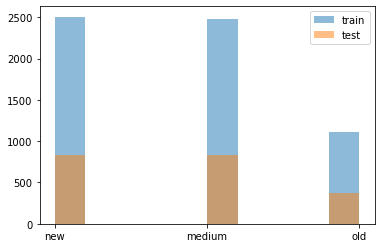

In [56]:
plt.hist(X_train.age_cat, alpha=0.5, label='train')
plt.hist(X_test.age_cat, alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.show()

After making the split we can drop `age_cat` feature:

In [57]:
X_train.drop('age_cat', axis=1, inplace=True)
X_test.drop('age_cat', axis=1, inplace=True)

/home/alex/anaconda3/envs/dat801/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Data preprocessing: Data cleaning, feature scaling and imputing missing data

Before we can use the data to train machine learning models we need to make sure it is "clean", the features are scaled, and think about how to deal with missing data.

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [59]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [60]:
imp = SimpleImputer()

In [61]:
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

# Training a regression model

As for classification, we have a lot of choices when building our model. For now, we'll use some of the standard built-in models in scikit-learn. 

In [62]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

We'll start by trying out a random forest model:

In [63]:
rf_reg = RandomForestRegressor(random_state=42)

In [64]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

The model is now trained on the training data, and we can use it to make predictions for the test data:

In [65]:
y_pred = rf_reg.predict(X_test)

Here are some of the 2032 predictions from the Random Forest:

In [66]:
len(y_pred), y_pred[:10]

(2032,
 array([129029.98      , 101889.975     , 698620.        , 647059.94      ,
        866160.        , 495687.47      , 375586.60666667, 349389.85      ,
        433949.93      , 164549.99      ]))

Here are some of the correct answers:

In [67]:
len(y_test), np.array(y_test)[:10]

(2032,
 array([ 90000,  88000, 740000, 567000, 525000, 370000, 375000, 399000,
        350000, 125000]))

Let's put them next to each other and print out the first few:

In [68]:
list(zip(y_test, y_pred))[:10] # "Zip" the two above arrays and display the first 10

[(90000, 129029.98),
 (88000, 101889.975),
 (740000, 698620.0),
 (567000, 647059.94),
 (525000, 866160.0),
 (370000, 495687.4700000001),
 (375000, 375586.6066666667),
 (399000, 349389.85),
 (350000, 433949.93),
 (125000, 164549.99)]

We observe that the model is close to correct some times, and way off for others. 

We can also make a scatter plot to compare the predicted prices agains the actual prices:

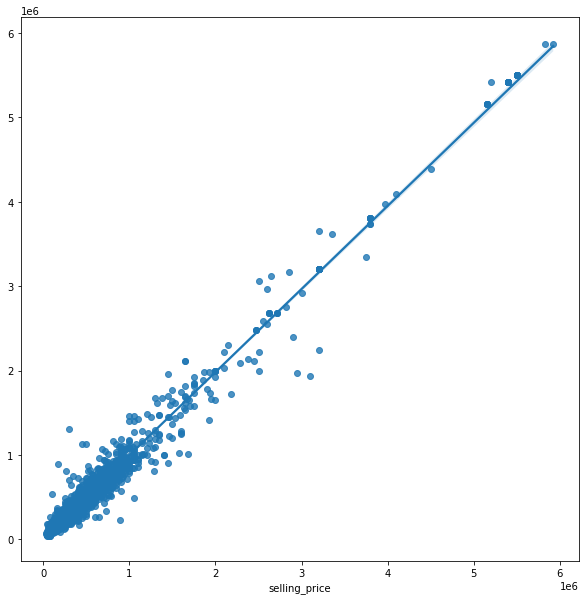

In [69]:
plt.figure(figsize=(10,10))
sns.regplot(x=y_test, y=y_pred)
plt.show()

We see that at least the model isn't extremely bad..

> **But how good is it, really? Can we quantify its performance?** 

As we did for classification earlier, we need metrics that we can use to evaluate our models. As before, we can use these to compare different models and choice of model parameters. 

# Evaluating models / performance measures

First of all, as mentioned earlier one should really ask "*What is the end goal for my system"?* We're supposed to create systems that are useful in some context, as part of a larger system, which typically has a higher-level goal that our system should aim to optimize. Perhaps it's worth sacrificing predictive performance for speed, or not getting a lot of prices that don't lead to sales?

However, we won't think about these broader context matters in these toy problems.

# TBC